In [35]:
import os #not necessary for this script
import kaggle.api
import zipfile # to extract data from zip archive
%matplotlib inline
from fastai.vision.all import *

In [2]:
# download the dataset
#!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [3]:
#zipfile.ZipFile('covid19-radiography-database.zip').extractall()

In [36]:
path = Path(os.getcwd())

In [37]:
path = path/"COVID-19 Radiography Database"

In [38]:
path

Path('/jet/prs/workspace/Detecting COVID-19 with Chest X-Ray using PyTorch/COVID-19 Radiography Database')

### Normalizatoin
Since we are usin the pretrained ImageNet model, we should to normalize the data according to statistics of ImageNet datdaset.

(If you do not pass any statistics to the Normalize transform, fastai will automatically calculate them from a single batch of your data.)

In [39]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [40]:
data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                             Normalize.from_stats(*imagenet_stats)])
dls = data.dataloaders(path, bs=128)

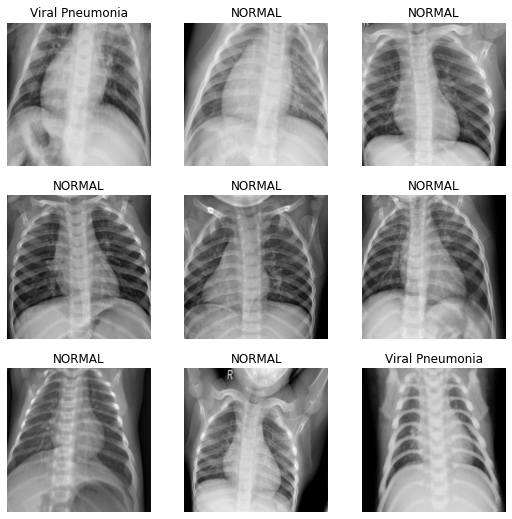

In [41]:
dls.show_batch(max_n=9)

In [44]:
# for Xresnet we should to specify the number of outputs n_out=dls.c
model = xresnet34(n_out=dls.c, pretrained=True)
learn = Learner(dls, model, metrics=accuracy)

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /jet/.cache/torch/hub/checkpoints/xrn50_940.pth


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0014454397605732083)

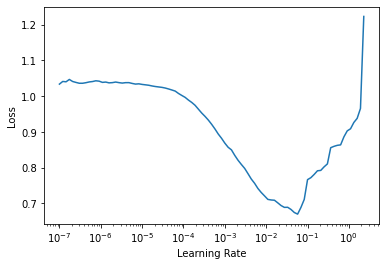

In [46]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.338054,4.218254,0.487091,06:25
1,0.299372,0.583219,0.846816,06:19
2,0.266799,0.306722,0.889845,06:14


In [49]:
# save model
learn.save('model_fastai')
# load learner model
#learn.load('model_fastai')

Path('models/model_fastai.pth')

In [10]:
learn = learn.load('model_fastai')

In [129]:
learn.model[-6]

Sequential(
  (0): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idpath): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): ConvLayer(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): ReLU(inplace=True)
  )
  (1): ResBlock(
    (convpath): Sequential(
      (0): ConvLayer(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

### CAM (Class activation map)
and Hooks, https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb

In [108]:
# grab the picture
img = PILImage.create(path/'COVID-19'/'COVID-19 (131).png')

In [109]:
# take an image like a tensor from dataloader
x, = first(dls.test_dl([img]))

In [110]:
x.shape # image after the for-batch transformation

torch.Size([1, 3, 224, 224])

In [111]:
F.softmax(learn.model.eval()(x), dim=-1)

TensorImage([[9.9755e-01, 2.4298e-03, 1.6191e-05]], grad_fn=<AliasBackward>)

In [101]:
dls.vocab

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [102]:
# class for forward hook to get the activations in the m layer
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [55]:
# class for backword hook to get the gradients
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [141]:
cls = 0 # COVID is the right label
with HookBwd(learn.model[-5]) as hookg:   # learn.model[-5]) - is a layer before AdaptiveAvgPool2d (last ConvLayer)
    with Hook(learn.model[-5]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [142]:
grad.shape, act.shape

(torch.Size([1, 512, 7, 7]), torch.Size([1, 512, 7, 7]))

In [145]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
w.shape, cam_map.shape

(torch.Size([512, 1, 1]), torch.Size([7, 7]))

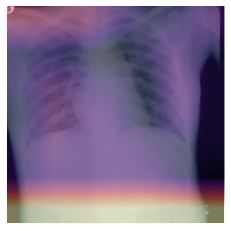

In [146]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

#### Progressive Resizing
start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher.

Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.

In [21]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                    splitter = RandomSplitter(seed=42),
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [22]:
dls = get_dls(128, 128)
learner = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [23]:
# compare with previous learning, there are faster training with greater accuracy
learner.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.483999,6.751375,0.070568,03:55
1,1.225216,0.443496,0.851979,03:58
2,0.802298,0.263051,0.900172,03:59


Then replace the DataLoaders inside the Learner, and fine-tune:

In [25]:
learner.dls = get_dls(64, 224)
learner.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.329780,0.356253,0.882960,09:58


epoch,train_loss,valid_loss,accuracy,time
0,0.283272,0.273792,0.907057,09:53
1,0.257862,0.269454,0.913942,09:49


### TTA - Test Time Augmentation
test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

You can pass any DataLoader to fastai's tta method; by default, it will use your validation set:

In [27]:
preds,targs = learner.tta()
accuracy(preds, targs).item()

0.9156626462936401

 it does make inference slower—if you're averaging five images for TTA, inference will be five times slower.

In [28]:
learner.save('resizing_model')

Path('models/resizing_model.pth')

### Label Smoothing
#### to prevent overfitting, 
In the theoretical expression of loss, in classification problems, our targets are one-hot encoded (in practice we tend to avoid doing this to save memory, but what we compute is the same loss as if we had used one-hot encoding). That means the model is trained to return 0 for all categories but one, for which it is trained to return 1. Even 0.999 is not "good enough", the model will get gradients and learn to predict activations with even higher confidence. This encourages overfitting and gives you at inference time a model that is not going to give meaningful probabilities: it will always say 1 for the predicted category even if it's not too sure, just because it was trained this way.

Instead, we could replace all our 1s with a number a bit less than 1, and our 0s by a number a bit more than 0, and then train. This is called label smoothing. By encouraging your model to be less confident, label smoothing will make your training more robust, even if there is mislabeled data. The result will be a model that generalizes better.

In [9]:
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.127821,2.538929,0.368330,10:16
1,2.132083,1.511201,0.812392,10:02
2,1.772017,1.361765,0.886403,10:11


In [10]:
??LabelSmoothingCrossEntropy()

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

In [23]:
interp.vocab.o2i

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

### Crearte validation data loaders

In [15]:
data_val = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 #splitter=RandomSplitter(seed=42),
                 #get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
path_val = Path('/jet/prs/workspace/Detecting COVID-19 with Chest X-Ray using PyTorch/validation')

In [17]:
get_image_files(path_val)

(#3) [Path('/jet/prs/workspace/Detecting COVID-19 with Chest X-Ray using PyTorch/validation/COVID-19_1.jpg'),Path('/jet/prs/workspace/Detecting COVID-19 with Chest X-Ray using PyTorch/validation/COVID-19_3.jpg'),Path('/jet/prs/workspace/Detecting COVID-19 with Chest X-Ray using PyTorch/validation/COVID-19_2.jpg')]

In [18]:
im1 = path_val/'COVID-19_1.jpg'

In [19]:
dl = learn.dls.test_dl(get_image_files(path_val))

In [20]:
learn.get_preds(dl=dl,with_decoded=True)[2]

TensorImage([0, 0, 0])

In [24]:
interp.vocab.map_ids(learn.get_preds(dl=dl, with_decoded=True)[2].tolist())

(#3) ['COVID-19','COVID-19','COVID-19']